In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

## Parametros

In [2]:
START_DATE = "2015-01-30"
INITIAL_CAPITAL = 250_000
RISK_FREE_RATE = 0.02  # 2% anual

## Carga de datos cartera

In [3]:
portfolio_daily = pd.read_parquet("resources/portfolio_daily.parquet")
parquet = pd.read_parquet("resources/assignment_parquet.parquet")

## Descarga de datos SPY

In [4]:
spy = yf.download("SPY", start=START_DATE, end="2026-01-31", auto_adjust=True)
# eliminamos el nivel extra
spy.columns = spy.columns.droplevel(1)
spy.index.name = 'date'
spy = spy.reset_index()

[*********************100%***********************]  1 of 1 completed


## Retornos diarios de la estrategia

In [5]:
portfolio_daily['daily_return'] = portfolio_daily['portfolio_value'].pct_change()

## Retornos diarios del SPY como benchmark

In [6]:
spy['daily_return'] = spy['Close'].pct_change()

In [7]:
print(f"Días estrategia: {len(portfolio_daily)}")
print(f"Días SPY: {len(spy)}")
print(f"SPY precio inicial: ${spy['Close'].iloc[0]:,.2f}")
print(f"SPY precio final:   ${spy['Close'].iloc[-1]:,.2f}")
print(f"SPY retorno acumulado: {(spy['Close'].iloc[-1] / spy['Close'].iloc[0] - 1) * 100:.2f}%")

Días estrategia: 2766
Días SPY: 2767
SPY precio inicial: $165.62
SPY precio final:   $691.97
SPY retorno acumulado: 317.80%


## Métricas - Cálculos

In [8]:
n_years = (portfolio_daily['date'].iloc[-1] - portfolio_daily['date'].iloc[0]).days / 365.25

### CAGR

In [9]:
cagr_strategy = (portfolio_daily['portfolio_value'].iloc[-1] / INITIAL_CAPITAL) ** (1 / n_years) - 1
cagr_spy = (spy['Close'].iloc[-1] / spy['Close'].iloc[0]) ** (1 / n_years) - 1

### Volatilidad anualizada

In [10]:
vol_strategy = portfolio_daily['daily_return'].std() * np.sqrt(252)
vol_spy = spy['daily_return'].std() * np.sqrt(252)

### Sharpe

In [11]:
sharpe_strategy = (cagr_strategy - RISK_FREE_RATE) / vol_strategy
sharpe_spy = (cagr_spy - RISK_FREE_RATE) / vol_spy

### Sortino

In [12]:
neg_strategy = portfolio_daily['daily_return'][portfolio_daily['daily_return'] < 0].std() * np.sqrt(252)
neg_spy = spy['daily_return'][spy['daily_return'] < 0].std() * np.sqrt(252)
sortino_strategy = (cagr_strategy - RISK_FREE_RATE) / neg_strategy
sortino_spy = (cagr_spy - RISK_FREE_RATE) / neg_spy

### Max Drawdown

#### Cartera

In [13]:
rolling_max = portfolio_daily['portfolio_value'].cummax()
drawdown = (portfolio_daily['portfolio_value'] - rolling_max) / rolling_max
max_dd_strategy = drawdown.min()

#### SPY

In [14]:
rolling_max_spy = spy['Close'].cummax()
drawdown_spy = (spy['Close'] - rolling_max_spy) / rolling_max_spy
max_dd_spy = drawdown_spy.min()

## Métricas - Resultados

In [15]:
print(f"{'':20} {'Estrategia':>12} {'SPY':>12}")
print(f"{'─'*44}")
print(f"{'CAGR':20} {cagr_strategy:>11.2%} {cagr_spy:>11.2%}")
print(f"{'Volatilidad':20} {vol_strategy:>11.2%} {vol_spy:>11.2%}")
print(f"{'Sharpe':20} {sharpe_strategy:>11.2f} {sharpe_spy:>11.2f}")
print(f"{'Sortino':20} {sortino_strategy:>11.2f} {sortino_spy:>11.2f}")
print(f"{'Max Drawdown':20} {max_dd_strategy:>11.2%} {max_dd_spy:>11.2%}")

                       Estrategia          SPY
────────────────────────────────────────────
CAGR                      17.82%      13.88%
Volatilidad               27.24%      17.75%
Sharpe                      0.58        0.67
Sortino                     0.73        0.81
Max Drawdown             -39.08%     -33.72%


## Beta y Alpha

In [16]:
merged = portfolio_daily[['date', 'daily_return']].merge(spy[['date', 'daily_return']], on='date', suffixes=('_strategy', '_spy'))
merged = merged.dropna()

cov = np.cov(merged['daily_return_strategy'], merged['daily_return_spy'])
beta = cov[0, 1] / cov[1, 1]
alpha = cagr_strategy - (RISK_FREE_RATE + beta * (cagr_spy - RISK_FREE_RATE))

print(f"{'Beta':20} {beta:>11.2f}")
print(f"{'Alpha':20} {alpha:>11.2%}")

Beta                        1.13
Alpha                      2.38%


In [17]:
metrics = {
    'CAGR':           [f'{cagr_strategy:.2%}',    f'{cagr_spy:.2%}'],
    'Volatilidad':    [f'{vol_strategy:.2%}',      f'{vol_spy:.2%}'],
    'Sharpe':         [f'{sharpe_strategy:.2f}',   f'{sharpe_spy:.2f}'],
    'Sortino':        [f'{sortino_strategy:.2f}',  f'{sortino_spy:.2f}'],
    'Max Drawdown':   [f'{max_dd_strategy:.2%}',   f'{max_dd_spy:.2%}'],
    'Beta':           [f'{beta:.2f}',              f'1.00'],
    'Alpha':          [f'{alpha:.2%}',             f'0.00%'],
}

tabla = pd.DataFrame(metrics, index=['Estrategia', 'SPY']).T
print(tabla.to_string())

             Estrategia      SPY
CAGR             17.82%   13.88%
Volatilidad      27.24%   17.75%
Sharpe             0.58     0.67
Sortino            0.73     0.81
Max Drawdown    -39.08%  -33.72%
Beta               1.13     1.00
Alpha             2.38%    0.00%


## Métricas - Gráficos

### Evolución Rentabilidad Acumulada

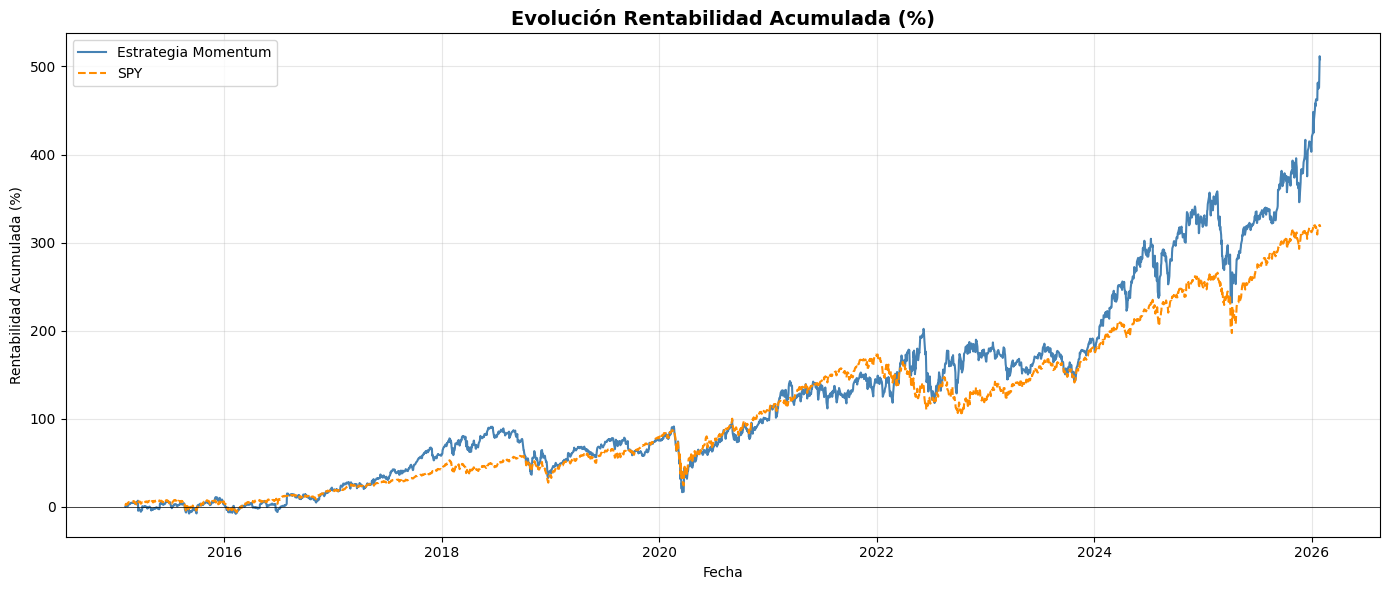

In [18]:
portfolio_daily['cum_return'] = (1 + portfolio_daily['daily_return']).cumprod() - 1
spy['cum_return'] = (1 + spy['daily_return']).cumprod() - 1

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(portfolio_daily['date'], portfolio_daily['cum_return'] * 100,
        label='Estrategia Momentum', color='steelblue', linewidth=1.5)
ax.plot(spy['date'], spy['cum_return'] * 100,
        label='SPY', color='darkorange', linewidth=1.5, linestyle='--')
ax.set_title('Evolución Rentabilidad Acumulada (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('Rentabilidad Acumulada (%)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

### Histograma de Retornos Mensuales

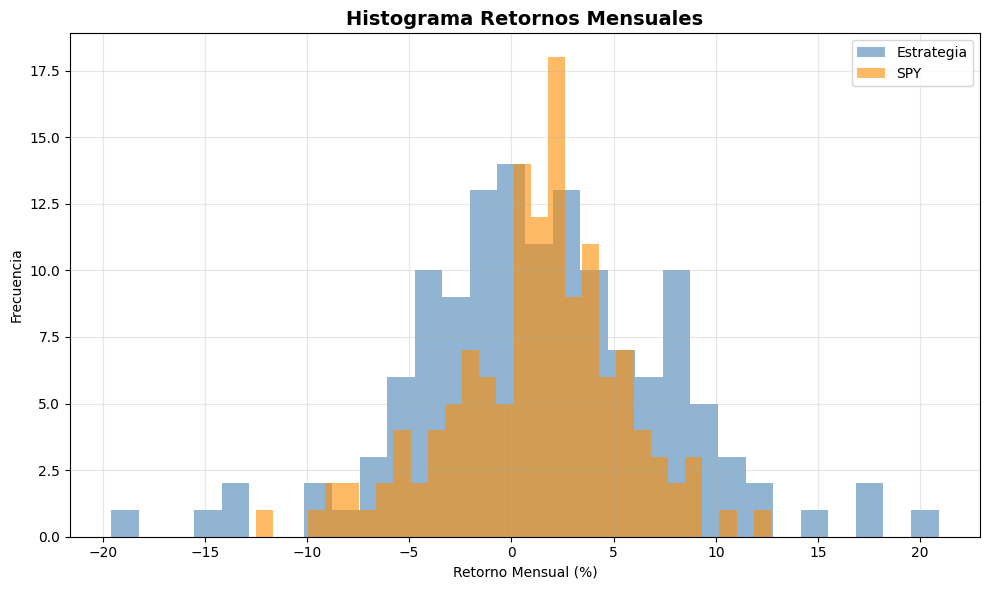

In [19]:
portfolio_daily['month'] = portfolio_daily['date'].dt.to_period('M')
spy['month'] = spy['date'].dt.to_period('M')

monthly_strategy = portfolio_daily.groupby('month')['daily_return'].apply(lambda x: (1+x).prod()-1)
monthly_spy = spy.groupby('month')['daily_return'].apply(lambda x: (1+x).prod()-1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(monthly_strategy * 100, bins=30, alpha=0.6, color='steelblue', label='Estrategia')
ax.hist(monthly_spy * 100, bins=30, alpha=0.6, color='darkorange', label='SPY')
ax.set_title('Histograma Retornos Mensuales', fontsize=14, fontweight='bold')
ax.set_xlabel('Retorno Mensual (%)')
ax.set_ylabel('Frecuencia')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('resources/grafico2_histograma.png', dpi=150, bbox_inches='tight')
plt.show()

### Scatter retornos trimestrales

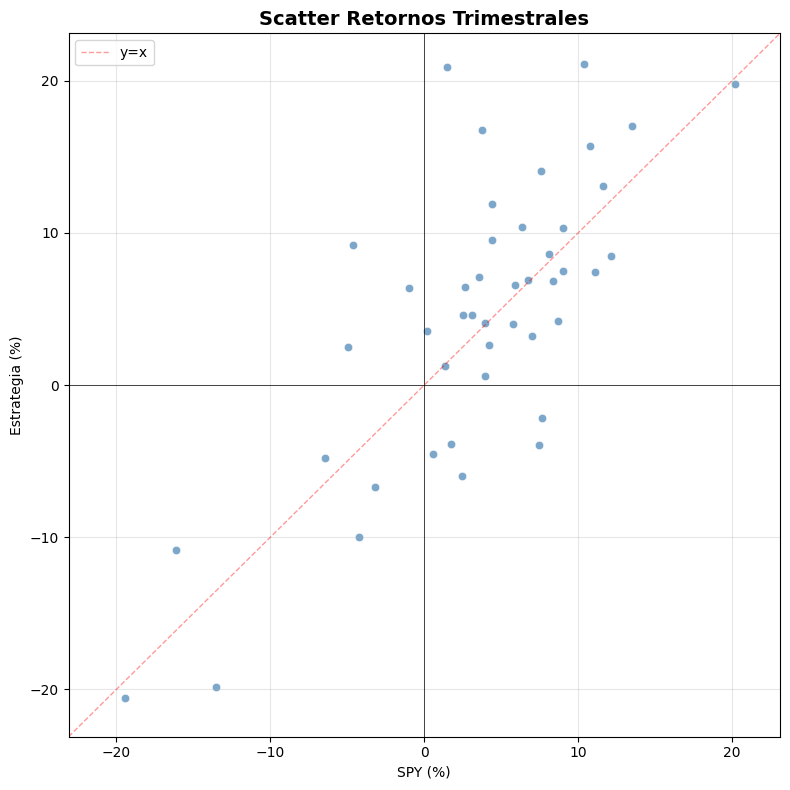

In [20]:
portfolio_daily['quarter'] = portfolio_daily['date'].dt.to_period('Q')
spy['quarter'] = spy['date'].dt.to_period('Q')

quarterly_strategy = portfolio_daily.groupby('quarter')['daily_return'].apply(lambda x: (1+x).prod()-1)
quarterly_spy = spy.groupby('quarter')['daily_return'].apply(lambda x: (1+x).prod()-1)
common_q = quarterly_strategy.index.intersection(quarterly_spy.index)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(quarterly_spy[common_q] * 100, quarterly_strategy[common_q] * 100,
           color='steelblue', alpha=0.7, edgecolors='white', linewidth=0.5)
lim = max(abs(quarterly_spy[common_q]).max(), abs(quarterly_strategy[common_q]).max()) * 100 + 2
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.plot([-lim, lim], [-lim, lim], 'r--', alpha=0.4, linewidth=1, label='y=x')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_title('Scatter Retornos Trimestrales', fontsize=14, fontweight='bold')
ax.set_xlabel('SPY (%)')
ax.set_ylabel('Estrategia (%)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('resources/grafico3_scatter_trimestral.png', dpi=150, bbox_inches='tight')
plt.show()

### Scatter retornos anuales

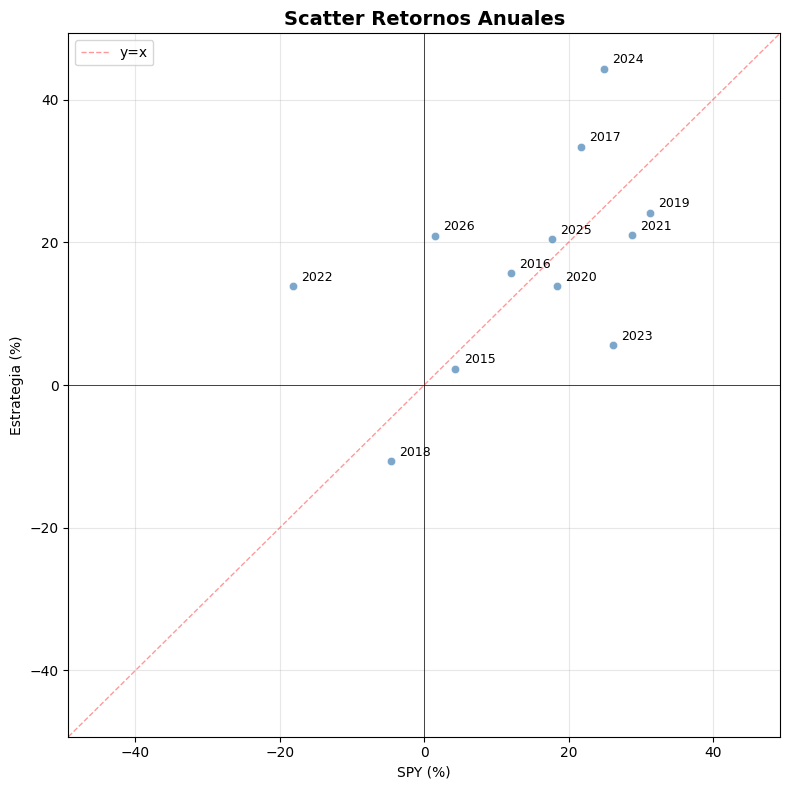

In [21]:
portfolio_daily['year'] = portfolio_daily['date'].dt.year
spy['year'] = spy['date'].dt.year

annual_strategy = portfolio_daily.groupby('year')['daily_return'].apply(lambda x: (1+x).prod()-1)
annual_spy = spy.groupby('year')['daily_return'].apply(lambda x: (1+x).prod()-1)
common_y = annual_strategy.index.intersection(annual_spy.index)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(annual_spy[common_y] * 100, annual_strategy[common_y] * 100,
           color='steelblue', alpha=0.7, edgecolors='white', linewidth=0.5, zorder=3)

for year in common_y:
    ax.annotate(str(year),
                (annual_spy[year] * 100, annual_strategy[year] * 100),
                textcoords='offset points', xytext=(6, 4), fontsize=9)

lim = max(abs(annual_spy[common_y]).max(), abs(annual_strategy[common_y]).max()) * 100 + 5
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.plot([-lim, lim], [-lim, lim], 'r--', alpha=0.4, linewidth=1, label='y=x')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_title('Scatter Retornos Anuales', fontsize=14, fontweight='bold')
ax.set_xlabel('SPY (%)')
ax.set_ylabel('Estrategia (%)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('resources/grafico4_scatter_anual.png', dpi=150, bbox_inches='tight')
plt.show()

## Monte Carlo

In [22]:
N_MONOS = 25_000_000
N_ASSETS = 20
COMMISSION_MONKEY = 0.0046  # 0.23% x2
BATCH_SIZE = 1_000_000

### Carga de datos

In [23]:
universe = pd.read_parquet("resources/universe.parquet")
monthly_closes = pd.read_parquet("resources/monthly_closes.parquet")
rebalancing_dates = pd.read_parquet("resources/rebalancing_dates.parquet")

### Generación del universo para los monos

In [24]:
monthly_closes['period'] = monthly_closes['date'].dt.to_period('M')

# Para cada fecha de rebalanceo cogemos los retornos del mes
monkey_returns = []

for _, row in rebalancing_dates.iterrows():
    rebal_date = row['date']
    t = rebal_date.to_period('M')

    # Todos los activos en el S&P 500 ese mes, sin filtro de 13 meses
    symbols_in_month = parquet[(parquet['date'] == rebal_date) & (parquet['in_sp500'] == 1)]['symbol'].tolist()

    mask = (
        (monthly_closes['period'] == t) &
        (monthly_closes['symbol'].isin(symbols_in_month))
    )

    rets = monthly_closes[mask]['log_return'].dropna().values
    monkey_returns.append(rets)

print(f"Periodos: {len(monkey_returns)}")
print(f"Media activos por periodo: {np.mean([len(r) for r in monkey_returns]):.0f}")
print(f"Retorno mensual medio universo: {np.mean([r.mean() for r in monkey_returns]):.4f}")

Periodos: 133
Media activos por periodo: 504
Retorno mensual medio universo: 0.0058


### Retornos por mono

In [25]:
n_periods =  len(rebalancing_dates)

max_assets = max(len(r) for r in monkey_returns)
monkey_matrix = np.full((n_periods, max_assets), np.nan, dtype=np.float32)
for t, r in enumerate(monkey_returns):
    monkey_matrix[t, :len(r)] = r

cagr_monos = np.zeros(N_MONOS)

np.random.seed(42)

In [26]:
n_years = n_periods / 12
n_batches = N_MONOS // BATCH_SIZE

start_time = pd.Timestamp.now()

for i in range(n_batches):

    batch_monthly = np.zeros((BATCH_SIZE, n_periods), dtype=np.float32)

    for t in range(n_periods):

        valid = ~np.isnan(monkey_matrix[t])
        n_valid = valid.sum()

        idx = np.random.randint(0, n_valid, size=(BATCH_SIZE, N_ASSETS))

        sampled = monkey_matrix[t, valid][idx]

        rets_simple = np.exp(sampled.mean(axis=1)) - 1
        rets_net = np.log((1 + rets_simple) * (1 - COMMISSION_MONKEY))  # restar comisión correctamente
        batch_monthly[:, t] = rets_net

    # aplicar costes
    batch_monthly -= COMMISSION_MONKEY

    # retorno total en log  pasar a simple
    total_return = np.exp(batch_monthly.sum(axis=1))
    cagr_monos[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = total_return**(1/n_years) - 1

    print(f"Batch {i+1}/{n_batches} completado")

elapsed = (pd.Timestamp.now() - start_time).total_seconds()
print(f"Tiempo total: {elapsed:.1f} segundos ")

Batch 1/25 completado
Batch 2/25 completado
Batch 3/25 completado
Batch 4/25 completado
Batch 5/25 completado
Batch 6/25 completado
Batch 7/25 completado
Batch 8/25 completado
Batch 9/25 completado
Batch 10/25 completado
Batch 11/25 completado
Batch 12/25 completado
Batch 13/25 completado
Batch 14/25 completado
Batch 15/25 completado
Batch 16/25 completado
Batch 17/25 completado
Batch 18/25 completado
Batch 19/25 completado
Batch 20/25 completado
Batch 21/25 completado
Batch 22/25 completado
Batch 23/25 completado
Batch 24/25 completado
Batch 25/25 completado
Tiempo total: 366.4 segundos 


In [27]:
print(f"Resultados Monte Carlo ({N_MONOS:,} simulaciones)")
print(f"{'─'*45}")
print(f"CAGR medio monos:     {cagr_monos.mean():.2%}")
print(f"CAGR mediano monos:   {np.median(cagr_monos):.2%}")
print(f"CAGR std monos:       {cagr_monos.std():.2%}")
print(f"CAGR mín monos:       {cagr_monos.min():.2%}")
print(f"CAGR máx monos:       {cagr_monos.max():.2%}")
print(f"{'─'*45}")
print(f"CAGR Estrategia:         {cagr_strategy:.2%}")
print(f"{'─'*45}")
percentile = (cagr_monos < cagr_strategy).mean() * 100
print(f"Percentil: {percentile:.1f}%")
print(f"Resultados superiores al {percentile:.1f}% de los monos")

Resultados Monte Carlo (25,000,000 simulaciones)
─────────────────────────────────────────────
CAGR medio monos:     -4.03%
CAGR mediano monos:   -4.04%
CAGR std monos:       1.69%
CAGR mín monos:       -12.88%
CAGR máx monos:       5.87%
─────────────────────────────────────────────
CAGR Estrategia:         17.82%
─────────────────────────────────────────────
Percentil: 100.0%
Resultados superiores al 100.0% de los monos


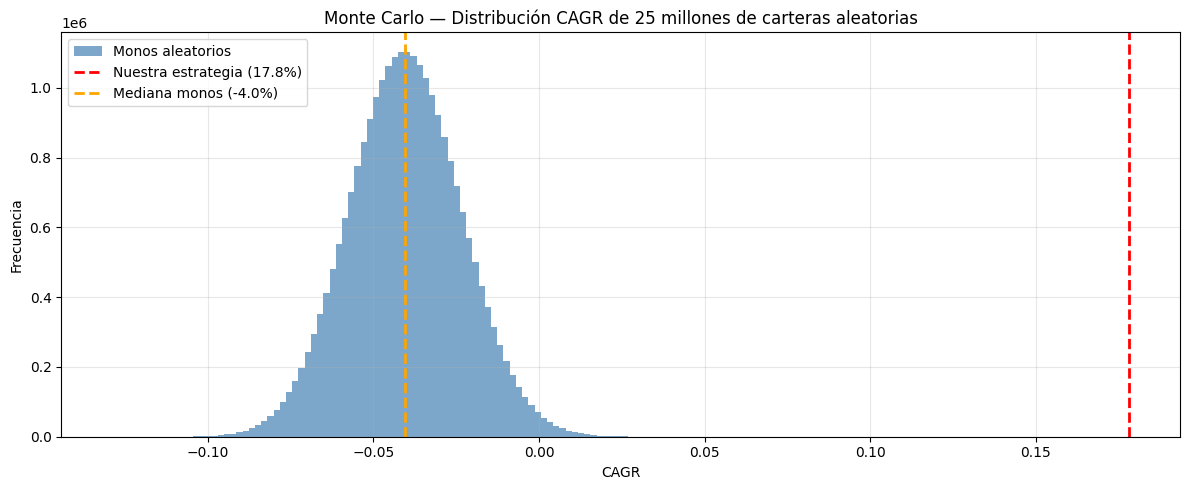

In [28]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(cagr_monos, bins=100, color='steelblue', alpha=0.7, label='Monos aleatorios')
ax.axvline(cagr_strategy, color='red', linewidth=2, linestyle='--', label=f'Nuestra estrategia ({cagr_strategy:.1%})')
ax.axvline(np.median(cagr_monos), color='orange', linewidth=2, linestyle='--', label=f'Mediana monos ({np.median(cagr_monos):.1%})')
ax.set_title('Monte Carlo — Distribución CAGR de 25 millones de carteras aleatorias')
ax.set_xlabel('CAGR')
ax.set_ylabel('Frecuencia')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Análisis Crítico

### Resultados generales

Nuestra estrategia de momentum ha generado un CAGR del 17.82% frente al 13.88% del SPY
en el periodo 2015-2026, lo que a priori parece un resultado muy bueno, sin embargo, pagamos más volatilidad por ese extra de rentabilidad: Mientras el SPY tiene una volatilidad anualizada del 17.75%, nuestra estrategia llega al 27.24%. Esto se refleja en un Sharpe de 0.58 frente al 0.67 del SPY — es decir, por unidad de riesgo asumido, el SPY lo hace mejor. Lo mismo pasa con el Sortino (0.73 vs 0.81) y el Max Drawdown
(-39.08% vs -33.72%).

Esto implica aguantar caídas del 39% en momentos de estrés.

La Beta de 1.13 confirma que nuestra cartera se mueve más que el mercado — cuando el SPY
sube un 1%, nosotros subimos un 1.13%, y cuando cae, caemos más. El Alpha del 2.38% indica
que sí generamos valor por encima de lo que explicaría simplemente tener más Beta, aunque
es un Alpha moderado.

### Sesgo de Supervivencia

El sesgo de supervivencia ocurre cuando solo usamos datos de empresas que han sobrevivido hasta hoy, ignorando las que quebraron o fueron eliminadas del índiceinflando los resultados.

En nuestro caso hemos mitigado este sesgo gracias a la columna `in_sp500` del dataset,
que refleja la composición histórica real del índice mes a mes. Esto significa que en enero
de 2015 solo consideramos los activos que realmente estaban en el S&P 500 en los últimos 13 meses, para nuestra estrategia y, el mes en curso, para la simulación.

### Lookahead Bias

El lookahead bias ocurre cuando el algoritmo usa información que no estaría disponible
en el momento de tomar la decisión. Hemos tomado varias decisiones de diseño para evitarlo:

**Filtro de 13 meses**: Para que un activo entre en el universo elegible, exigimos que
haya estado en el S&P 500 durante los 13 meses anteriores al rebalanceo. Esto evita
incluir empresas que entran al índice justo ese mes y de las que no tendríamos histórico
suficiente para calcular el momentum.

**Exclusión del mes actual**: El cálculo de R_12 y R_6 excluye el mes actual del
rebalanceo (t), usando solo hasta t-1. Esto evita usar el retorno del mes en curso,
que no estaría disponible en el momento de tomar la decisión.

**Ejecución Open/Close**: Vendemos al precio de apertura y compramos al precio de cierre
del día de rebalanceo, no usando precios futuros.

### Overfitting

El overfitting ocurre cuando un modelo se ajusta demasiado bien a los datos históricos
pero falla en datos nuevos.

En nuestro caso hay varios factores que reducen el riesgo de overfitting:

**Parámetros fijos del enunciado**: Los parámetros principales, ventanas de 6 y 12 meses,
top 20, peso del 5% que nos ha dado el enunciado directamente eliminan el riesgo de ajuste post-hoc.

**Estrategia sólida**: La estrategia replica la metodología del ETF MSCI Momentum

**Periodo largo**: 11 años de datos con 133 rebalanceos mensuales nos dan una muestra estadísticamente significativa que cubre bull market (2015-2021), crash COVID (2020), crisis de tipos (2022), recuperación (2023-2026).

### Impacto de las Comisiones

Las comisiones han tenido un impacto muy significativo en nuestra estrategia. En total
hemos pagado **106.954** dólares en comisiones de compraventa — el 42.7% del capital inicial
de 250.000$.

El rebalanceo mensual implica una rotación frecuente de cartera. Cada mes vendemos las posiciones que salen y compramos las que entran, pagando comisión en cada operación. Con una comisión del 0.23% y un mínimo de 23$ por orden, las operaciones pequeñas se ven especialmente penalizadas por ese mínimo fijo. Para reducir este gasto, las posiciones que se mantienen de un mes al siguiente no se reajustan, por lo que no se hace un rebalanceo estricto al 5%

A pesar de pagar 107k$ en comisiones, la estrategia ha multiplicado el capital por 6x en 11 años. Esto sugiere que el alpha generado por el factor momentum es lo suficientemente robusto como para absorber los costes transaccionales y seguir superando al benchmark.

### Test de Monte Carlo

Para validar que nuestra estrategia genera valor real y no es simplemente el resultado
de la suerte, hemos comparado nuestros resultados contra 25 millones de carteras aleatorias.

Cada mono selecciona 20 activos aleatorios del S&P 500 cada mes y paga una comisión del 0.46% (0.23% de compra + 0.23% de venta), asumiendo rotación completa de cartera cada mes sin mínimo por orden.

Los resultados son:

- **CAGR medio de los monos**: 0.89%
- **CAGR máximo de los monos**: 10.88%
- **Nuestro CAGR**: 17.82%
- **Percentil**: 100% — superamos a todos los monos

Nuestra estrategia supera a los 25 millones de carteras aleatorias. El CAGR medio de los monos es bajo porque seleccionan aleatoriamente; cada mono mezcla ganadores y perdedores del universo, obteniendo aproximadamente el retorno medio del mercado equi-ponderado menos comisiones.

Nuestra estrategia en cambio selecciona los 20 activos con mayor momentum lo que explica que superemos consistentemente la selección aleatoria.

Para que un mono igualara nuestra estrategia necesitaría seleccionar casualmente los mejores 20 activos del universo durante 133 meses consecutivos sin ninguna lógica de selección

Respecto al tiempo de ejecución de los 25 millones de simulaciones fue de aproximadamente
7 minutos, muy por debajo del límite de 24 horas establecido en el enunciado.

**¿Hemos realizado un rebalanceo irrealista?**

Hay simplificaciones respecto a la realidad como ignorar el slippage o el spread bid-ask, pero al trabajar con activos del S&P 500, que son líquidos, el impacto sería mínimo.Además, como no reajustamos las posiciones que se mantienen cada mes, seguimos una estrategia bastante realista.